In [1]:
%matplotlib inline

# Welcome to Exercise 05
1) Vanilla seq2seq training 코드 짜기<br>
2) auto-encoder로 만들고 인코더 저장. 그 상태에서 번역을 위한 새로운 디코더 학습

## 기초부터 시작하는 NLP: Sequence to Sequence 네트워크와 Attention을 이용한 번역
**Author**: `Sean Robertson`
**번역**: `황성수`

이 튜토리얼은 "기초부터 시작하는 NLP"의 세번째이자 마지막 편으로, NLP 모델링 작업을
위한 데이터 전처리에 사용할 자체 클래스와 함수들을 작성해보겠습니다.
이 튜토리얼을 마친 뒤에는 `torchtext` 가 어떻게 지금까지의 튜토리얼들에서의
전처리 과정을 다루는지를 이후 튜토리얼들에서 배울 수 있습니다.

이 프로젝트에서는 신경망이 불어를 영어로 번역하도록 가르칠 예정입니다.


    [KEY: > input, = target, < output]

    > il est en train de peindre un tableau .
    = he is painting a picture .
    < he is painting a picture .

    > pourquoi ne pas essayer ce vin delicieux ?
    = why not try that delicious wine ?
    < why not try that delicious wine ?

    > elle n est pas poete mais romanciere .
    = she is not a poet but a novelist .
    < she not not a poet but a novelist .

    > vous etes trop maigre .
    = you re too skinny .
    < you re all alone .

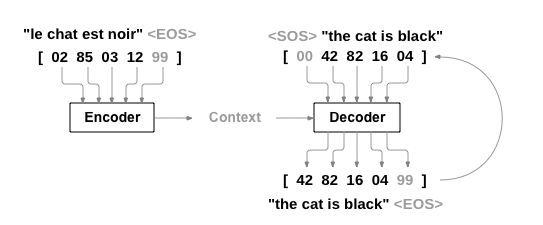

성공율은 변할 수 있습니다.

하나의 시퀀스를 다른 시퀀스로 바꾸는 두개의 RNN이 함께 동작하는
`sequence to sequence network <https://arxiv.org/abs/1409.3215>`의 간단하지만 강력한 아이디어가
이것(번역)을 가능하게 합니다. 인코더 네트워크는 입력 시퀀스를 벡터로 압축하고,
디코더 네트워크는 해당 벡터를 새로운 시퀀스로 펼칩니다.

이 모델을 개선하기 위해 `Attention Mechanism` 을
사용하면 디코더가 입력 시퀀스의 특정 범위에 집중할 수 있도록 합니다.

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

In [3]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu' # for debug

데이터 파일 로딩
==================

이 프로젝트의 데이터는 수천 개의 영어-프랑스어 번역 쌍입니다.

`Open Data Stack Exchange`에 관한 이 질문은 https://tatoeba.org/eng/downloads 에서 다운 로드가 가능한
공개 번역 사이트 https://tatoeba.org/ 를 알려 주었습니다. 더 나은 방법으로
언어 쌍을 개별 텍스트 파일로 분할하는 추가 작업을 수행한
https://www.manythings.org/anki/ 가 있습니다:

영어-프랑스어 쌍이 너무 커서 저장소에 포함 할 수 없기 때문에
계속하기 전에 ``data/eng-fra.txt`` 로 다운로드하십시오.
이 파일은 탭으로 구분된 번역 쌍 목록입니다:

문자 단위 RNN 튜토리얼에서 사용된 문자 인코딩과 유사하게, 언어의 각
단어들을 One-Hot 벡터 또는 그 단어의 주소에만 단 하나의 1을 제외하고
모두 0인 큰 벡터로 표현합니다. 한 가지 언어에 있는 수십 개의 문자와
달리 번역에는 아주 많은 단어들이 있기 때문에 인코딩 벡터는 매우 더 큽니다.
그러나 우리는 약간의 트릭를 써서 언어 당 수천 단어 만
사용하도록 데이터를 다듬을 것입니다.

나중에 네트워크의 입력 및 목표로 사용하려면 단어 당 고유 번호가
필요합니다. 이 모든 것을 추적하기 위해 우리는
단어→색인(``word2index``)과 색인→단어(``index2word``) 사전,
그리고 나중에 희귀 단어를 대체하는데 사용할 각 단어의 빈도
``word2count`` 를 가진 ``Lang`` 이라는 헬퍼 클래스를 사용합니다.




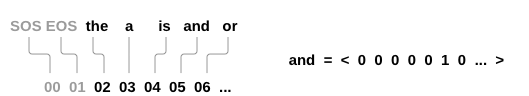

In [4]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # SOS 와 EOS 포함

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

파일은 모두 유니 코드로 되어있어 간단하게하기 위해 유니 코드 문자를
ASCII로 변환하고, 모든 문자를 소문자로 만들고, 대부분의 구두점을
지워줍니다.




In [5]:
# 유니 코드 문자열을 일반 ASCII로 변환하십시오.
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# 소문자, 다듬기, 그리고 문자가 아닌 문자 제거
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

To read the data file we will split the file into lines, and then split
lines into pairs. The files are all English → Other Language, so if we
want to translate from Other Language → English I added the ``reverse``
flag to reverse the pairs.




In [6]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # 파일을 읽고 줄로 분리
    lines = open('data/data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # 모든 줄을 쌍으로 분리하고 정규화
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # 쌍을 뒤집고, Lang 인스턴스 생성
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

*많은* 예제 문장이 있고 신속하게 학습하기를 원하기 때문에
비교적 짧고 간단한 문장으로만 데이터 셋을 정리할 것입니다. 여기서
최대 길이는 10 단어 (종료 문장 부호 포함)이며 "I am" 또는
"He is" 등의 형태로 번역되는 문장으로 필터링됩니다.(이전에
아포스트로피는 대체 됨)




In [8]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

데이터 준비를 위한 전체 과정:

-  텍스트 파일을 읽고 줄로 분리하고, 줄을 쌍으로 분리합니다.
-  텍스트를 정규화 하고 길이와 내용으로 필터링 합니다.
-  쌍을 이룬 문장들로 단어 리스트를 생성합니다.




In [9]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:", end='\t')
    print(input_lang.name, input_lang.n_words, end=' ')
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:	fra 4345 eng 2803
['je cuis !', 'i m baking !']


In [126]:
import pickle

In [128]:
with open('data/input_lang.p', 'wb') as f:
    pickle.dump(input_lang, f)
with open('data/output_lang.p', 'wb') as f:
    pickle.dump(output_lang, f)
with open('data/pairs.p', 'wb') as f:
    pickle.dump(pairs, f)

## Seq2Seq 모델

Recurrent Neural Network(RNN)는 시퀀스에서 작동하고 다음 단계의
입력으로 자신의 출력을 사용하는 네트워크입니다.

`Sequence to Sequence network`, 또는
Seq2Seq 네트워크, 또는 `Encoder Decoder network`는 인코더 및
디코더라고 하는 두 개의 RNN으로 구성된 모델입니다.
인코더는 입력 시퀀스를 읽고 단일 벡터를 출력하고,
디코더는 해당 벡터를 읽어 출력 시퀀스를 생성합니다.

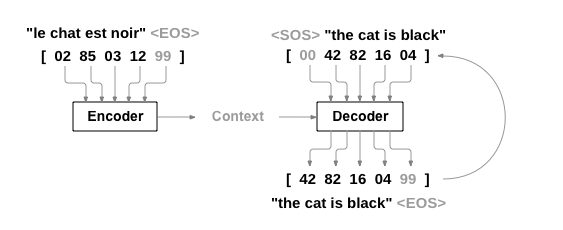

모든 입력에 해당하는 출력이 있는 단일 RNN의 시퀀스 예측과 달리
Seq2Seq 모델은 시퀀스 길이와 순서를 자유롭게하기 때문에
두 언어 사이의 번역에 이상적입니다.

다음 문장 "Je ne suis pas le chat noir" → "I am not the black cat"
를 살펴 봅시다. 입력 문장의 단어 대부분은 출력 문장에서
직역("chat noir" 와 "black cat")되지만 약간 다른 순서도 있습니다. 
"ne/pas" 구조로 인해 입력 문장에 단어가 하나 더 있습니다.
입력 단어의 시퀀스를 직역해서 정확한 번역을 만드는
것은 어려울 것입니다.

Seq2Seq 모델을 사용하면 인코더는 하나의 벡터를 생성합니다.
이상적인 경우에 입력 시퀀스의 "의미"를 문장의 N 차원 공간에 있는
단일 지점인 단일 벡터으로 인코딩합니다.

### 인코더

Seq2Seq 네트워크의 인코더는 입력 문장의 모든 단어에 대해 어떤 값을
출력하는 RNN입니다. 모든 입력 단어에 대해 인코더는 벡터와
은닉 상태를 출력하고 다음 입력 단어를 위해 그 은닉 상태를 사용합니다.

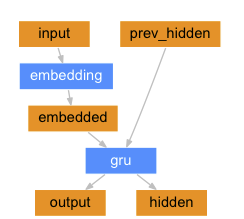

In [10]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size) # input_size, hidden_size

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1) 
        # 1(seq_len) by 1(batch_size) by -1(hidden_size)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## 디코더

디코더는 인코더 출력 벡터를 받아서 번역을 생성하기 위한 단어 시퀀스를
출력합니다.

간단한 디코더

가장 간단한 Seq2Seq 디코더는 인코더의 마지막 출력만을 이용합니다.
이 마지막 출력은 전체 시퀀스에서 문맥을 인코드하기 때문에
*문맥 벡터(context vector)* 로 불립니다. 이 문맥 벡터는 디코더의 초기 은닉 상태로
사용 됩니다.

디코딩의 매 단계에서 디코더에게 입력 토큰과 은닉 상태가 주어집니다.
초기 입력 토큰은 문자열-시작 (start-of-string) ``<SOS>`` 토큰이고,
첫 은닉 상태는 문맥 벡터(인코더의 마지막 은닉 상태) 입니다.

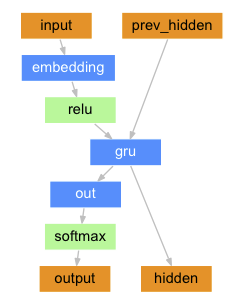

In [11]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        # decoder이기 때문에 input_size 대신 hidden_size
        # hidden_size 대신에 output_size
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size) 
        self.gru = nn.GRU(hidden_size, hidden_size) # input_size, hidden_size
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden) 
        output = self.softmax(self.out(output[0])) # output으로 나가는 layer가 따로 있음
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

# 1) Vanilla seq2seq 학습 코드 짜기



학습
========

학습 데이터 준비
-----------------------

학습을 위해서, 각 쌍마다 입력 Tensor(입력 문장의 단어 주소)와
목표 Tensor(목표 문장의 단어 주소)가 필요합니다. 이 벡터들을
생성하는 동안 두 시퀀스에 EOS 토큰을 추가 합니다.




In [12]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [13]:
pairs[:3]

[['j ai ans .', 'i m .'],
 ['je vais bien .', 'i m ok .'],
 ['ca va .', 'i m ok .']]

In [14]:
hidden_size = 128
learning_rate = 0.0005
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = DecoderRNN(hidden_size, output_lang.n_words).to(device)
criterion = nn.NLLLoss()
encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

In [15]:
from tqdm import tqdm

In [16]:
loss_history = []
for idx, pair in enumerate(tqdm(pairs)):
    loss = 0
    
    input_tensor, target_tensor = tensorsFromPair(pair)
    
    # check shape 
    input_tensor.unsqueeze_(1) # 5(seq_len) by 1(batch_size) by 1(word_index)

    # get length of input / target tensor
    input_length = input_tensor.size(0)    # sequence length for input
    target_length = target_tensor.size(0)  # sequence length for target
    
    #### Encoder Layer ####
    # init hidden layer
    encoder_hidden = encoder.initHidden()
    
    # training token by token
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        
    #### Decoder Layer ####
    decoder_hidden = decoder.initHidden()
    decoder_input = torch.tensor([[SOS_token]], device=device)
    
    # get output token by token
    # teach forcing 
    for di in range(target_length):
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
        top_value, top_index = decoder_output.topk(1) # highest score, index of highest score tensor 
        loss += criterion(decoder_output, target_tensor[di])
        decoder_input = target_tensor[di] # teach forcing
    
    if idx % 100 == 0:
        loss_history.append(loss)
        
    loss.backward()
    
    encoder_optimizer.step()
    decoder_optimizer.step()    

100%|██████████| 10599/10599 [01:18<00:00, 135.68it/s]


In [17]:
import matplotlib.pyplot as plt

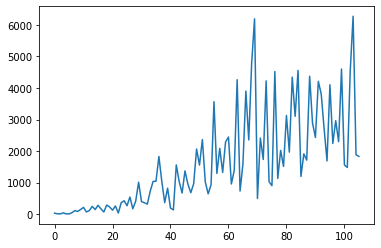

In [18]:
plt.plot(loss_history)

# 2) auto-encoder 학습하기

In [19]:
pairs_self = [[french, french] for french, english in pairs]

In [57]:
output_lang = input_lang # output_lang is same with input_lang
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = DecoderRNN(hidden_size, output_lang.n_words).to(device) 
# redefine decoder because of output_lang changed.

In [58]:
EncoderRNNloss_history = []
for idx, pair in enumerate(tqdm(pairs_self)):
    loss = 0

    input_tensor, target_tensor = tensorsFromPair(pair)

    # check shape 
    input_tensor.unsqueeze_(1) # 5(seq_len) by 1(batch_size) by 1(word_index)

    # get length of input / target tensor
    input_length = input_tensor.size(0)    # sequence length for input
    target_length = target_tensor.size(0)  # sequence length for target

    #### Encoder Layer ####
    # init hidden layer
    encoder_hidden = encoder.initHidden()

    # training token by token
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)

    #### Decoder Layer ####
    decoder_hidden = decoder.initHidden()
    decoder_input = torch.tensor([[SOS_token]], device=device)

    # get output token by token
    # teach forcing 
    for di in range(target_length):
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
        top_value, top_index = decoder_output.topk(1) # highest score, index of highest score tensor 
        loss += criterion(decoder_output, target_tensor[di])
        decoder_input = target_tensor[di] # teach forcing

    if idx % 100 == 0:
        loss_history.append(loss)

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()    


100%|██████████| 10599/10599 [02:39<00:00, 66.54it/s]


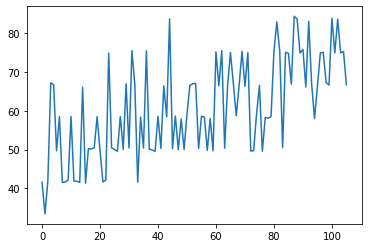

In [59]:
plt.plot(loss_history)

## save / load encoder

In [65]:
# model과 weight 저장하기
torch.save(encoder, 'data/encoder.path')
encoder = torch.load('data/encoder.path')

In [69]:
encoder

EncoderRNN(
  (embedding): Embedding(4345, 256)
  (gru): GRU(256, 256)
)

In [61]:
# weight만 저장하기
state_dict = encoder.state_dict()
torch.save(state_dict, 'data/encoder_weight.path')
encoder_weight = torch.load('data/encoder_weight.path')

In [70]:
encoder.load_state_dict(encoder_weight)
encoder

EncoderRNN(
  (embedding): Embedding(4345, 256)
  (gru): GRU(256, 256)
)

## Encoder weight를 가지고 decoder만들기 

In [104]:
input_lang, output_lang, pairs = prepareData('eng', 'fra', True)

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:	fra 4345 eng 2803


## Attention 디코더

문맥 벡터만 인코더와 디코더 사이로 전달 된다면, 단일 벡터가 전체 문장을
인코딩 해야하는 부담을 가지게 됩니다.

Attention은 디코더 네트워크가 자기 출력의 모든 단계에서 인코더 출력의
다른 부분에 "집중" 할 수 있게 합니다. 첫째 *Attention 가중치* 의 세트를
계산합니다. 이것은 가중치 조합을 만들기 위해서 인코더 출력 벡터와
곱해집니다. 그 결과(코드에서 ``attn_applied``)는 입력 시퀀스의
특정 부분에 관한 정보를 포함해야하고 따라서 디코더가 알맞은 출력
단어를 선택하는 것을 도와줍니다.

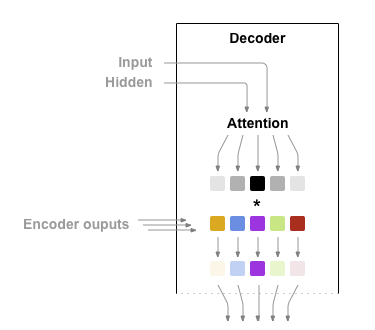

어텐션 가중치 계산은 디코더의 입력 및 은닉 상태를 입력으로
사용하는 다른 feed-forwad 계층인 ``attn`` 으로 수행됩니다.
학습 데이터에는 모든 크기의 문장이 있기 때문에 이 계층을 실제로
만들고 학습시키려면 적용 할 수 있는 최대 문장 길이 (인코더 출력을 위한 입력 길이)를
선택해야 합니다. 최대 길이의 문장은 모든 Attention 가중치를 사용하지만
더 짧은 문장은 처음 몇 개만 사용합니다.

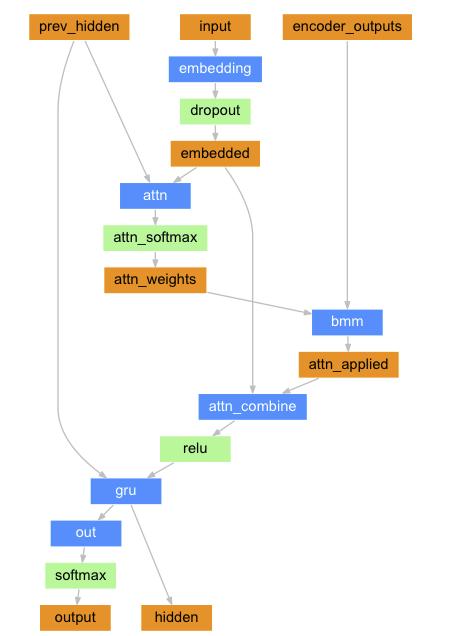

In [105]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        # prev_hidden(hidden_size) + embedded(hidden_size) = hidden_size * 2
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        
        # attention score
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),    # 0번째 차원(batch)를 만듦
                                 encoder_outputs.unsqueeze(0)) # 0번째 차원(batch)를 만듦 
        # bmm : batch matrix-matrix product
        # (b x n x m) @ (b x m x p) -> (b x n x p) 
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

모델 학습
------------------

학습을 위해서 인코더에 입력 문장을 넣고 모든 출력과 최신 은닉 상태를
추적합니다. 그런 다음 디코더에 첫 번째 입력으로 ``<SOS>`` 토큰과
인코더의 마지막 은닉 상태가 첫번쩨 은닉 상태로 제공됩니다.

"Teacher forcing"은 다음 입력으로 디코더의 예측을 사용하는 대신
실제 목표 출력을 다음 입력으로 사용하는 컨셉입니다.
"Teacher forcing"을 사용하면 수렴이 빨리되지만 학습된 네트워크가
잘못 사용될 때 불안정성을 보입니다.

Teacher-forced 네트워크의 출력이 일관된 문법으로 읽지만 정확한
번역과는 거리가 멀다는 것을 볼 수 있습니다. 직관적으로 출력 문법을
표현하는 법을 배우고 교사가 처음 몇 단어를 말하면 의미를 "선택" 할 수 있지만,
번역에서 처음으로 문장을 만드는 법은 잘 배우지 못합니다.

PyTorch의 autograd 가 제공하는 자유 덕분에 간단한 If 문으로
Teacher Forcing을 사용할지 아니면 사용하지 않을지를 선택할 수 있습니다.
더 많이 사용하려면 ``teacher_forcing_ratio`` 를 확인하십시오.




In [106]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, 
          encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0
    with torch.no_grad():
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(
                input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing 포함: 목표를 다음 입력으로 전달
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Teacher forcing 미포함: 자신의 예측을 다음 입력으로 사용
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # 입력으로 사용할 부분을 히스토리에서 분리 

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

이것은 현재 시간과 진행률%을 고려해 경과된 시간과 남은 예상
시간을 출력하는 헬퍼 함수입니다.




In [107]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

전체 학습 과정은 다음과 같습니다:

-  타이머 시작
-  optimizers와 criterion 초기화
-  학습 쌍의 세트 생성
-  도식화를 위한 빈 손실 배열 시작

그런 다음 우리는 여러 번 ``train`` 을 호출하며 때로는 진행률
(예제의 %, 현재까지의 예상 시간)과 평균 손실을 출력합니다.




In [115]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # print_every 마다 초기화
    plot_loss_total = 0   # plot_every 마다 초기화

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

결과 도식화
----------------

matplotlib로 학습 중에 저장된 손실 값 ``plot_losses`` 의 배열을
사용하여 도식화합니다.




In [116]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # 주기적인 간격에 이 locator가 tick을 설정
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

평가
==========

평가는 대부분 학습과 동일하지만 목표가 없으므로 각 단계마다 디코더의
예측을 되돌려 전달합니다.
단어를 예측할 때마다 그 단어를 출력 문자열에 추가합니다.
만약 EOS 토큰을 예측하면 거기에서 멈춥니다.
나중에 도식화를 위해서 디코더의 Attention 출력을 저장합니다.




In [117]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

학습 세트에 있는 임의의 문장을 평가하고
입력, 목표 및 출력을 출력하여 주관적인 품질 판단을 내릴 수 있습니다:




In [118]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs_self)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

## 학습과 평가


이러한 모든 헬퍼 함수를 이용해서 (추가 작업처럼 보이지만 여러 실험을
더 쉽게 수행 할 수 있음) 실제로 네트워크를 초기화하고 학습을
시작할 수 있습니다.

입력 문장이 많이 필터링되었음을 기억하십시오. 이 작은 데이터 세트의
경우 256 크기의 은닉 노드(hidden node)와 단일 GRU 계층 같은 상대적으로 작은
네트워크를 사용할 수 있습니다. MacBook CPU에서 약 40분 후에
합리적인 결과를 얻을 것입니다.

1m 6s (- 15m 37s) (5000 6%) 2.9280
2m 16s (- 14m 44s) (10000 13%) 2.5062
3m 23s (- 13m 32s) (15000 20%) 2.3492
4m 26s (- 12m 14s) (20000 26%) 2.2079
5m 30s (- 11m 1s) (25000 33%) 2.1327
6m 34s (- 9m 51s) (30000 40%) 2.0021
7m 37s (- 8m 43s) (35000 46%) 1.9097
8m 42s (- 7m 37s) (40000 53%) 1.8361
9m 48s (- 6m 32s) (45000 60%) 1.7666
10m 54s (- 5m 27s) (50000 66%) 1.6781
12m 0s (- 4m 22s) (55000 73%) 1.6188
13m 6s (- 3m 16s) (60000 80%) 1.5472
14m 11s (- 2m 11s) (65000 86%) 1.5130
15m 16s (- 1m 5s) (70000 93%) 1.4710
16m 22s (- 0m 0s) (75000 100%) 1.4420


<Figure size 432x288 with 0 Axes>

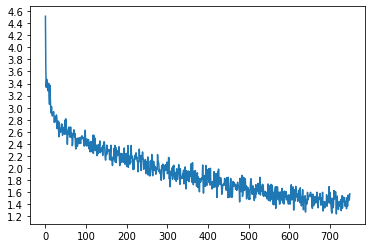

In [120]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

In [121]:
evaluateRandomly(encoder1, attn_decoder1)

> je n ecris pas a votre sujet .
= je n ecris pas a votre sujet .
< i m not at your you . <EOS>

> elle est en train de reparer la machine .
= elle est en train de reparer la machine .
< she s good . <EOS>

> j ai peur de la mort .
= j ai peur de la mort .
< i m afraid forward to . . <EOS>

> vous etes vraiment apre au travail .
= vous etes vraiment apre au travail .
< you re really a hard . <EOS>

> je ne suis pas heureux dans mon travail .
= je ne suis pas heureux dans mon travail .
< i m not in at all . <EOS>

> il ne cesse de me surprendre .
= il ne cesse de me surprendre .
< he s not a about . . <EOS>

> je fais du benevolat .
= je fais du benevolat .
< i m looking for my . . <EOS>

> je suis ravie .
= je suis ravie .
< i m being . <EOS>

> nous sommes completement cool avec ca .
= nous sommes completement cool avec ca .
< we re going a with with . <EOS>

> je n ai vraiment pas faim .
= je n ai vraiment pas faim .
< i m really not that . <EOS>



Attention 시각화
---------------------

Attention 메커니즘의 유용한 속성은 하나는 해석 가능성이 높은 출력입니다.
입력 시퀀스의 특정 인코더 출력에 가중치를 부여하는 데 사용되므로
각 시간 단계에서 네트워크가 가장 집중되는 위치를 파악할 수 있습니다.

Attention 출력을 행렬로 표시하기 위해 ``plt.matshow(attentions)`` 를
간단하게 실행할 수 있습니다. 열은 입력 단계와 행이 출력 단계입니다:




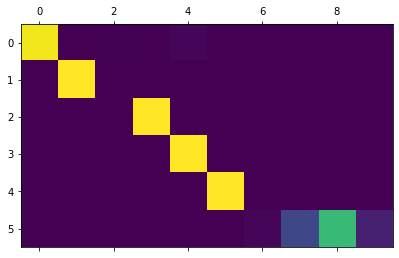

In [122]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "je suis trop froid .")
plt.matshow(attentions.numpy())

더 나은 보기를 위해 축과 라벨을 더하는 추가 작업을 수행합니다:




input = elle a cinq ans de moins que moi .
output = she s two years older than i am . <EOS>
input = elle est trop petit .
output = she s too loud . <EOS>
input = je ne crains pas de mourir .
output = i m not afraid to die . <EOS>
input = c est un jeune directeur plein de talent .
output = he s a young man of his . <EOS>


/home/long8v/anaconda3/envs/long36v/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.
/home/long8v/anaconda3/envs/long36v/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()
/home/long8v/anaconda3/envs/long36v/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


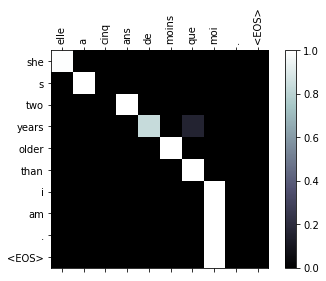

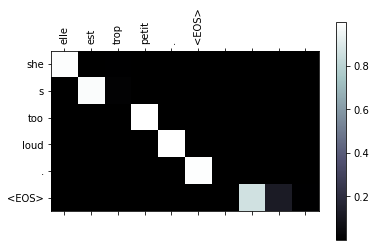

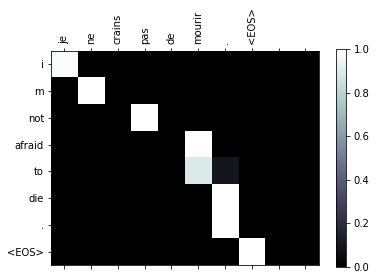

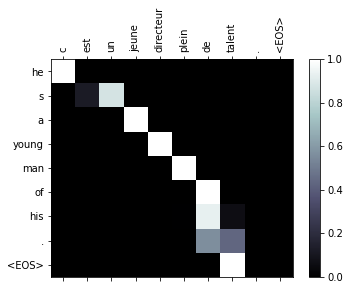

In [123]:
g.word2index[word] fordef showAttention(input_sentence, output_words, attentions):
    # colorbar로 그림 설정
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # 축 설정
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # 매 틱마다 라벨 보여주기
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")

연습
=========

-  다른 데이터 셋을 시도해 보십시오

   -  다른 언어쌍
   -  사람 → 기계 (e.g. IOT 명령어)
   -  채팅 → 응답
   -  질문 → 답변

-  word2vec 또는 GloVe 같은 미리 학습된 word embedding 으로
   embedding 을 교체하십시오

-  더 많은 레이어, 은닉 유닛, 더 많은 문장을 사용하십시오.
   학습 시간과 결과를 비교해 보십시오
-  만약 같은 구문 두개의 쌍으로 된 번역 파일을 이용한다면,
   (``I am test \t I am test``), 이것을 오토인코더로
   사용할 수 있습니다.
   이것을 시도해 보십시오:

   -  오토인코더 학습
   -  인코더 네트워크 저장하기
   -  그 상태에서 번역을 위한 새로운 디코더 학습


